# Main Goal

The main goal of this assignment is to predict future values of the US GDP, in order to use these predictions to decide whether to tilt the allocation of our investment fund toward equities or bonds. For this purpose, I will use Time Series models, i.e. AR, MA, ARIMA, SARIMA. In case our forecasts will point at a positive GDP growth, we will then allocate the fund's capital toward equities, otherwise to bonds. 

# Dataset Description

For this specific case, I will use the GDP dataset from the Fed of St. Louis (https://fred.stlouisfed.org/series/GDP#0). This time series is released on a quarterly basis and goes back to 1947. It is possible to download it from the FRED Economic Data website through API.

In [1]:
#Import relevant libraries for data fetching
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
plt.style.use('seaborn-bright')
import warnings
warnings.filterwarnings('ignore')
from fredapi import Fred
fred = Fred(api_key='my_key')
import statsmodels.api as sm

In [3]:
#GDP data fetch
gdp = fred.get_series('GDP', frequency='q')
gdp.head()

1946-01-01        NaN
1946-04-01        NaN
1946-07-01        NaN
1946-10-01        NaN
1947-01-01    243.164
dtype: float64

In [65]:
gdp.tail()

2020-07-01    21138.574
2020-10-01    21477.597
2021-01-01    22038.226
2021-04-01    22740.959
2021-07-01    23202.344
dtype: float64

# Data Exploration and Feature Engineering

In [4]:
gdp.shape

(303,)

In [5]:
round(gdp.describe(), 2)

count      299.00
mean      6561.01
std       6649.98
min        243.16
25%        760.59
50%       4009.60
75%      11117.78
max      23202.34
dtype: float64

In [6]:
gdp.dropna(inplace=True)
gdp.shape

(299,)

In [7]:
gdp.isnull().sum()

0

From the plot below we can immediately notice that the time series has a trend component, so we have to keep this in mind while applying our models later.

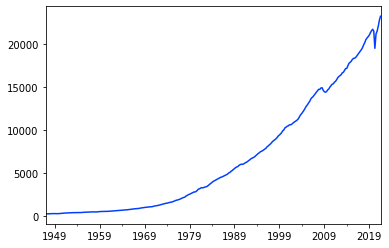

In [9]:
# line chart to uncover any trend component 
gdp.plot();

From the violin plot below, we can exclude any seasonal component from the time series components.

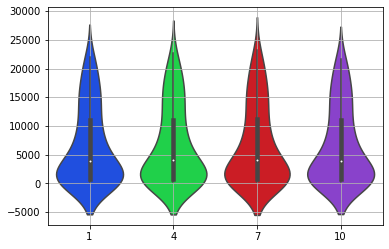

In [10]:
# violinplot of quarters to determine variance and range
sns.violinplot(x=gdp.index.month, y=gdp)
plt.grid(b=True);

Now let's divide the series in equal size chuncks to determine whether the series suffers from heteroskedasticity.

In [11]:
# split data into 4 chunks
chunks = np.split(gdp[3:], indices_or_sections=8)
mean_vals = np.mean(chunks,axis=1)
var_vals = np.var(chunks,axis=1)
vals = {'mean_vals': mean_vals , 'var_vals': var_vals}
mean_var = pd.DataFrame(vals)
round(mean_var, 2)

,mean_vals,var_vals
0,354.66,3859.74
1,589.03,8569.30
2,1160.82,65342.33
3,2794.02,482777.31
4,5533.96,730746.95
5,9170.50,1631769.79
6,14072.94,1714377.71
7,19324.16,3570380.83


We immediately notice that series has mean and variance that are not constant, thus we can assume it is a non-stationary time series. Let's formally check this with an ADF test.

In [12]:
# define Dickey-Fuller Test (DFT) function
# Null is that unit root is present, rejection means likely stationary
import statsmodels.tsa.stattools as ts

def dftest(timeseries):
    dftest = ts.adfuller(timeseries,)
    dfoutput = pd.Series(dftest[0:4], 
                         index=['Test Statistic','p-value','Lags Used','Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=4).mean()
    rolstd = timeseries.rolling(window=4).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.grid()
    plt.show(block=False)

Test Statistic            5.528513
p-value                   1.000000
Lags Used                 8.000000
Observations Used       290.000000
Critical Value (1%)      -3.453102
Critical Value (5%)      -2.871559
Critical Value (10%)     -2.572108
dtype: float64


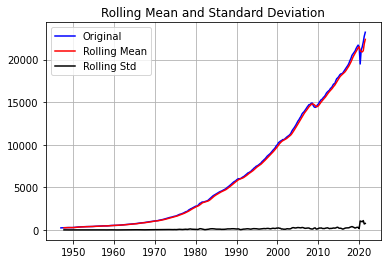

In [13]:
# run DFT on original data
dftest(gdp)
# p-value allows us to reject a unit root: data is stationary

Now we have our confirmation that the series is not stationary, so we may need to take the log of it to make the variance constant and de-trend it.

In [14]:
gdp_log = np.log(gdp)

In [15]:
gdp_log.head()

1947-01-01    5.493736
1947-04-01    5.505201
1947-07-01    5.519800
1947-10-01    5.559700
1948-01-01    5.582526
dtype: float64

In [16]:
# split log data into 4 chunks
chunks_log = np.split(gdp_log[3:], indices_or_sections=8)
mean_vals_log = np.mean(chunks_log,axis=1)
var_vals_log = np.var(chunks_log,axis=1)
vals_log = {'mean_vals': mean_vals_log , 'var_vals': var_vals_log}
mean_var_log = pd.DataFrame(vals_log)
round(mean_var_log, 2)

,mean_vals,var_vals
0,5.86,0.03
1,6.37,0.02
2,7.03,0.05
3,7.90,0.07
4,8.61,0.02
5,9.11,0.02
6,9.55,0.01
7,9.86,0.01


We notice that after the log transformation the variance of the different chunks is now constant, but this may not be sufficient to declare this series as stationary. Let's run another ADF test on the log series to confirm our hypothesis.

Test Statistic           -2.345013
p-value                   0.157861
Lags Used                 2.000000
Observations Used       296.000000
Critical Value (1%)      -3.452637
Critical Value (5%)      -2.871354
Critical Value (10%)     -2.571999
dtype: float64


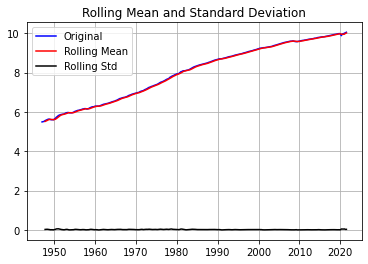

In [17]:
# run DFT on log values
dftest(gdp_log)
# p-value allows us to reject a unit root: data is stationary

Once again we see that the p-value leads us to reject the alternative hypothesis (i.e., data is not stationary again). We still see the trend component in the series, so we may need to calculate percentage change to detrend it and make it stationary.

In [18]:
gdp_pct = gdp_log.pct_change()
gdp_pct.dropna(inplace=True)

Test Statistic           -2.152424
p-value                   0.223964
Lags Used                16.000000
Observations Used       281.000000
Critical Value (1%)      -3.453838
Critical Value (5%)      -2.871881
Critical Value (10%)     -2.572280
dtype: float64


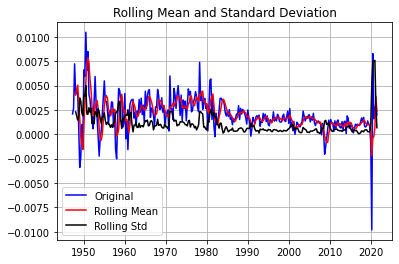

In [19]:
# run DFT on percentage log values
dftest(gdp_pct)
# p-value allows us to reject a unit root: data is stationary

Even with a one-quarter percentage change calculation, we notice from the ADF test that the series cannot be considered as stationary yet. We may consider to detrend it even more, using a 4-quarter percentage change and see if things improve. Maybe there are yearly patterns that we haven't noticed.

In [20]:
gdp_pct_4 = gdp_log.pct_change(4)
gdp_pct_4.dropna(inplace=True)

Test Statistic           -1.739837
p-value                   0.410713
Lags Used                16.000000
Observations Used       278.000000
Critical Value (1%)      -3.454094
Critical Value (5%)      -2.871993
Critical Value (10%)     -2.572340
dtype: float64


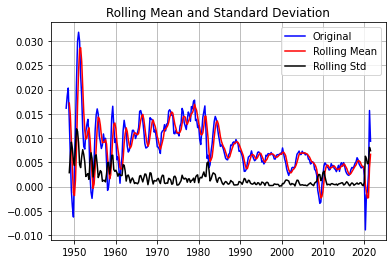

In [21]:
# run DFT on percentage log values
dftest(gdp_pct_4)
# p-value allows us to reject a unit root: data is stationary

Despite having increased the time window of the percentage change calculation, we still can't reject the null hypothesis. Therefore, we should change strategy and try with a simple difference instead of using the percentage change.

In [22]:
gdp_diff = gdp_log.diff()
gdp_diff.dropna(inplace=True)

Test Statistic         -8.588037e+00
p-value                 7.415103e-14
Lags Used               1.000000e+00
Observations Used       2.960000e+02
Critical Value (1%)    -3.452637e+00
Critical Value (5%)    -2.871354e+00
Critical Value (10%)   -2.571999e+00
dtype: float64


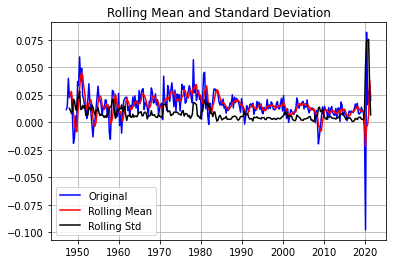

In [23]:
# run DFT on percentage log values
dftest(gdp_diff)
# p-value allows us to reject a unit root: data is stationary

Finally, we have managed to transform the series in a stationary one. The spike in 2020 is clearly due to the impact of Covid-19, so we shall not worry about that. We can now move to the ACF and PACF plots to decide which models to apply.

In [24]:
# define helper plot function for visualization
def plots(data, lags=None):
    plt.figure(figsize=(12,6))
    layout = (1, 3)
    raw  = plt.subplot2grid(layout, (0, 0))
    acf  = plt.subplot2grid(layout, (0, 1))
    pacf = plt.subplot2grid(layout, (0, 2))
    
    raw.plot(data)
    sm.tsa.graphics.plot_acf(data, lags=lags, ax=acf, zero=False)
    sm.tsa.graphics.plot_pacf(data, lags=lags, ax=pacf, zero = False)
    sns.despine()
    plt.tight_layout()

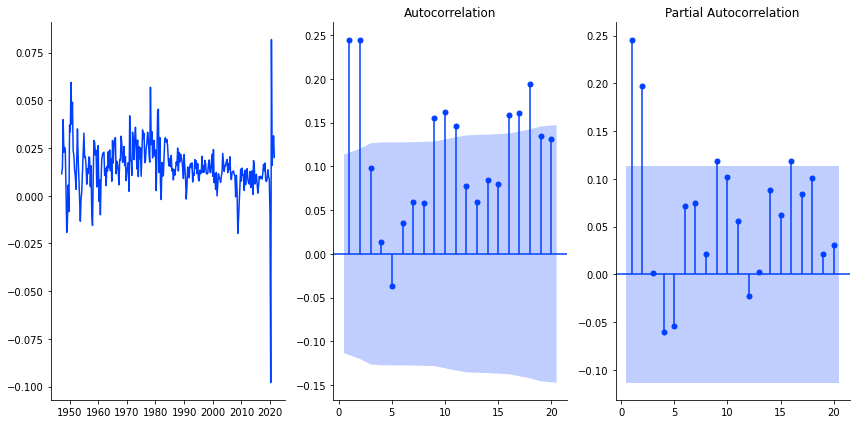

In [25]:
plots(gdp_diff, lags=20)

Given these output, we shall opt for an AR or ARMA model, but, in order to be sure that the series is really stationary and doesn't need further differencing, we will apply the difference to the already-differenced series and plot the ACF and PACF plots.

Test Statistic         -8.484638e+00
p-value                 1.363726e-13
Lags Used               1.600000e+01
Observations Used       2.800000e+02
Critical Value (1%)    -3.453922e+00
Critical Value (5%)    -2.871918e+00
Critical Value (10%)   -2.572300e+00
dtype: float64


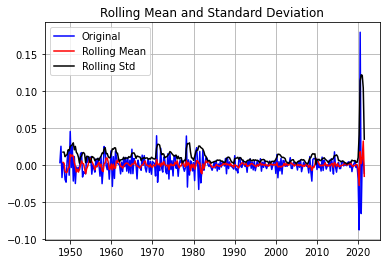

In [26]:
gdp_diff_2 = gdp_diff.diff()
gdp_diff_2.dropna(inplace=True)
dftest(gdp_diff_2)

The series is clearly stationary, but given the ACF plot with a negative value of -0.5 at lag-1, we may have over-differenced the our series. So, we decide to stick with the original differenced series.

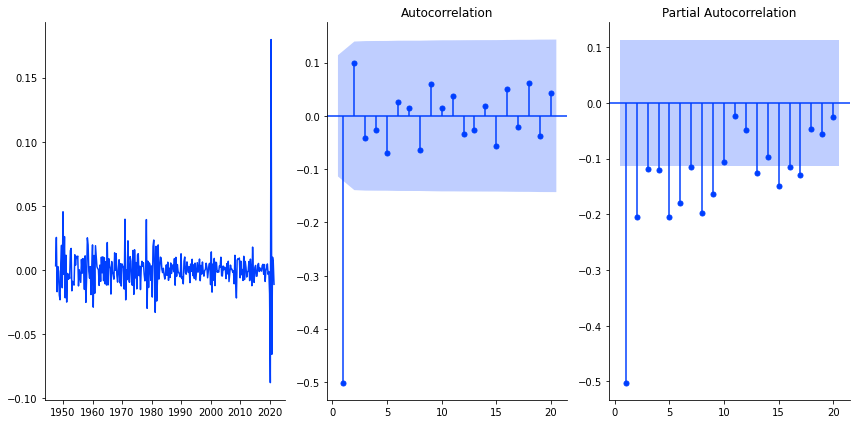

In [27]:
plots(gdp_diff_2, lags=20)

# AR model

From the above ACF and PACF charts we can assume that starting with a simple AR-2 model can be a good idea. So, let's implement the model and evaluate the results. 

### [Box-Jenkins Method](https://en.wikipedia.org/wiki/Box–Jenkins_method)

ACF Shape|Indicated Model
---|---
Exponential, decaying to zero|Autoregressive model. Use the partial autocorrelation plot to identify the order of the autoregressive model.
Alternating positive and negative, decaying to zero|Autoregressive model. Use the partial autocorrelation plot to help identify the order.
One or more spikes, rest are essentially zero|Moving average model, order identified by where plot becomes zero.
Decay, starting after a few lags|Mixed autoregressive and moving average (ARMA) model.
All zero or close to zero|Data are essentially random.
High values at fixed intervals|Include seasonal autoregressive term.
No decay to zero|Series is not stationary.

In [28]:
# AR 2 model
ar_2 = sm.tsa.statespace.SARIMAX(gdp_diff,
                                order=(2, 0, 0),
                                seasonal_order=(0, 0, 0, 0),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

ar_2_res = ar_2.fit()

print(ar_2_res.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  298
Model:               SARIMAX(2, 0, 0)   Log Likelihood                 849.742
Date:                Fri, 24 Dec 2021   AIC                          -1693.484
Time:                        10:17:07   BIC                          -1682.413
Sample:                    04-01-1947   HQIC                         -1689.051
                         - 07-01-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4038      0.022     18.214      0.000       0.360       0.447
ar.L2          0.4042      0.046      8.715      0.000       0.313       0.495
sigma2         0.0002   5.79e-06     32.470      0.0

/Users/lucadonghi/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  warnings.warn('No frequency information was'
/Users/lucadonghi/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  warnings.warn('No frequency information was'


We notice that the residuals diagnostics shows good results, with most of the observations around 0 and lying on the line in the Q-Q plot.

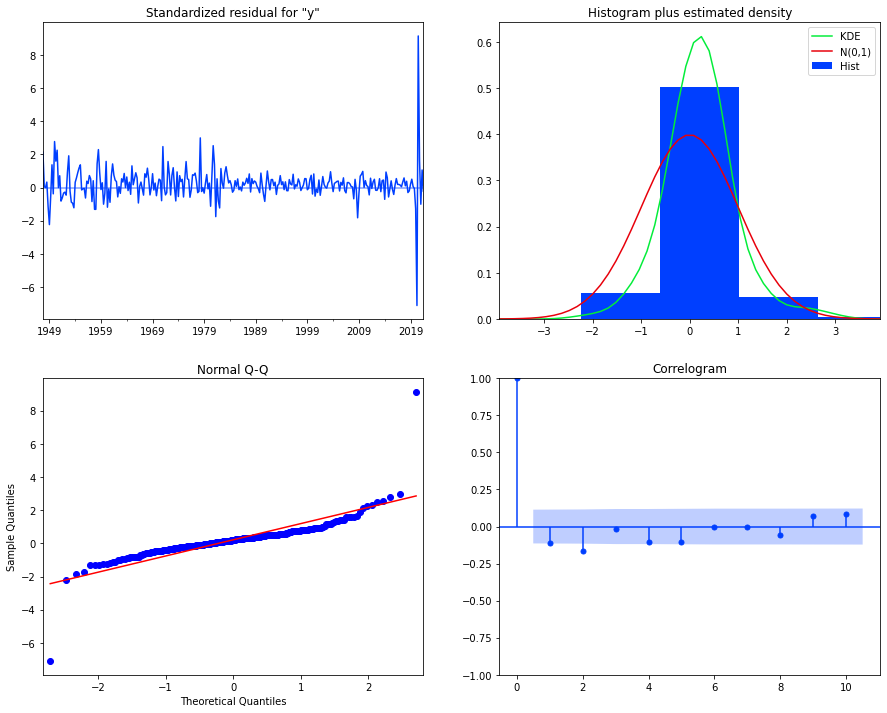

In [29]:
ar_2_res.plot_diagnostics(figsize=(15, 12))
plt.show()

In [30]:
ar_2_pred = ar_2_res.get_prediction(start=pd.to_datetime('1990-01-01'), dynamic=False)
ar_2_pred_ci = ar_2_pred.conf_int()

From the chart below we notice that the one-step ahead produce discrete results, even though not perfect. Nevertheless, the MSE of 0.00024 is encouraging.

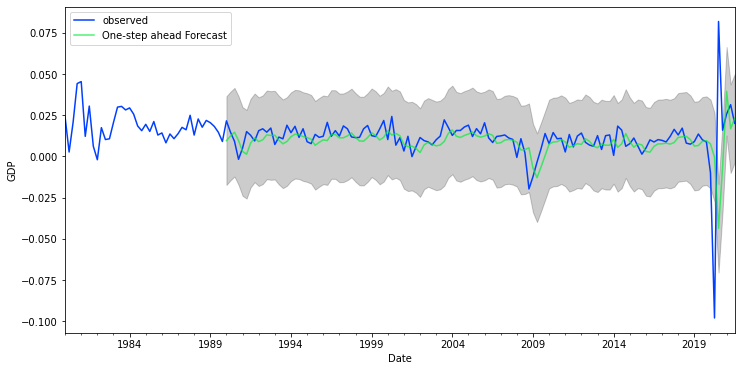

In [32]:
ax = gdp_diff['1980':].plot(label='observed', figsize=(12, 6))
ar_2_pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)

ax.fill_between(ar_2_pred_ci.index,
                ar_2_pred_ci.iloc[:, 0],
                ar_2_pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('GDP')
plt.legend()

plt.show()
 


In [33]:
ar_2_forecasted = ar_2_pred.predicted_mean
gdp_truth = gdp_diff['1990-01-01':]

# Compute the mean square error
mse = ((ar_2_forecasted - gdp_truth) ** 2).mean()
print('The Mean Squared Error of AR 2 forecasts is {}'.format(round(mse, 5)))

The Mean Squared Error of AR 2 forecasts is 0.00024


In [34]:
# Get forecast n steps ahead in future
ar_2_pred_uc = ar_2_res.get_forecast(steps=4)

# Get confidence intervals of forecasts
ar_2_pred_ci = ar_2_pred_uc.conf_int()

From the 4 steps ahead forecast, we notice that the GDP is expected to decline in the coming four quarters, hence we should recommend an allocation tilted toward bonds in this case.

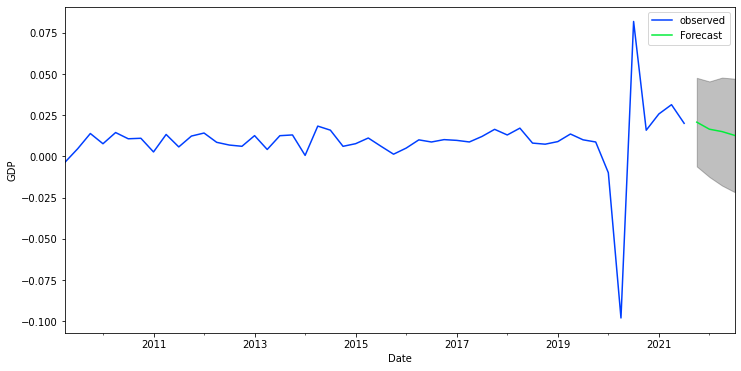

In [35]:
ax = gdp_diff[-50:].plot(label='observed', figsize=(12, 6))
ar_2_pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(ar_2_pred_ci.index,
                ar_2_pred_ci.iloc[:, 0],
                ar_2_pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('GDP')

plt.legend()
plt.show()

# Autofit model

We now move to the application of other models and see if our results will improve. For this purpose, we are going to use the auto-ARIMA function and see what models the method suggests to us.

In [36]:
import pmdarima as pm

## ARIMA

Let's start with pmdarima without allowing for the seasonality.

In [57]:
#Auto-ARIMA on log detrended series
auto_model_5 = pm.auto_arima(gdp_diff, 
                             seasonal=False,
                             trace=True,
                             error_action='ignore',  
                             suppress_warnings=True, 
                             stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-1742.088, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1597.074, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1680.579, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1737.666, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1599.073, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-1733.766, Time=0.19 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-1730.232, Time=0.22 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-1739.879, Time=0.38 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-1726.471, Time=0.14 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1742.180, Time=0.20 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-1740.628, Time=0.28 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-1691.248, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-1743.845, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-1739.417, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0

The pmdarima suggests an ARIMA (2,1,1) model with no intercept as the best model. The residual diagnostics seem also to be encouraging, with the residuals lying quite well on the line of the Q-Q plot. 

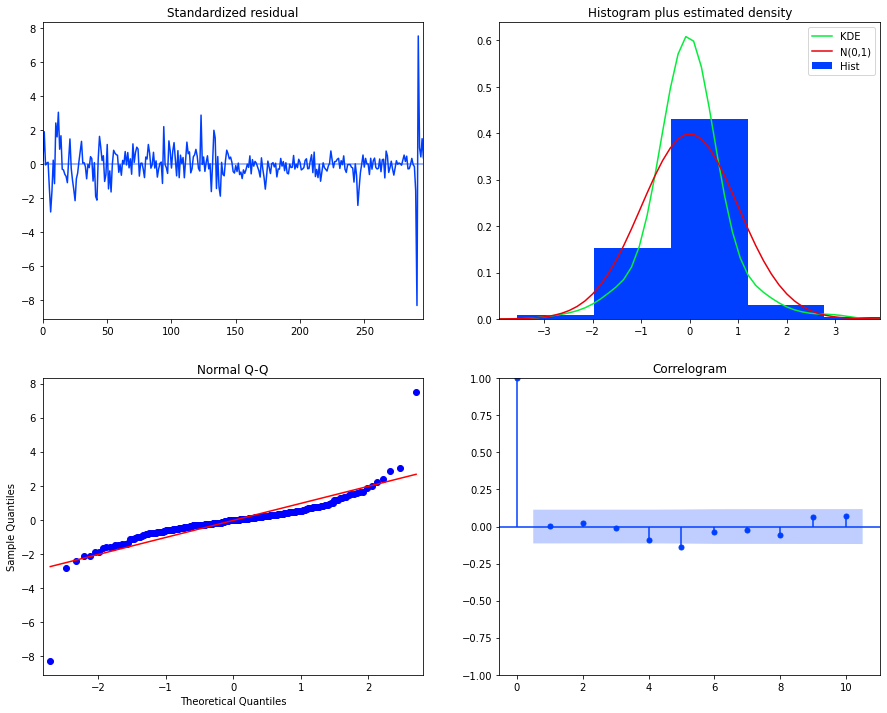

In [58]:
auto_model_5.plot_diagnostics(figsize=(15, 12))
plt.show()

In [59]:
# ARIMA model
arima = sm.tsa.statespace.SARIMAX(gdp_diff,
                                order=(2, 1, 1),
                                seasonal_order=(0, 0, 0, 0),
                                enforce_stationarity=False,
                                enforce_invertibility=False,
                                trend=None)

arima_res = arima.fit()

print(arima_res.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  298
Model:               SARIMAX(2, 1, 1)   Log Likelihood                 870.638
Date:                Fri, 24 Dec 2021   AIC                          -1733.276
Time:                        10:49:00   BIC                          -1718.528
Sample:                    04-01-1947   HQIC                         -1727.370
                         - 07-01-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1390      0.036      3.894      0.000       0.069       0.209
ar.L2          0.1392      0.064      2.159      0.031       0.013       0.266
ma.L1         -1.0364      0.026    -39.746      0.0

/Users/lucadonghi/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  warnings.warn('No frequency information was'
/Users/lucadonghi/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  warnings.warn('No frequency information was'
/Users/lucadonghi/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [60]:
arima_res_pred = arima_res.get_prediction(start=pd.to_datetime('1990-01-01'), dynamic=False)
arima_res_pred_ci = arima_res_pred.conf_int()

From the chart below, we can see that the forecast is quite smooth compared to the real output. Nevertheless, MSE remains quite low, in line with our precedent results.

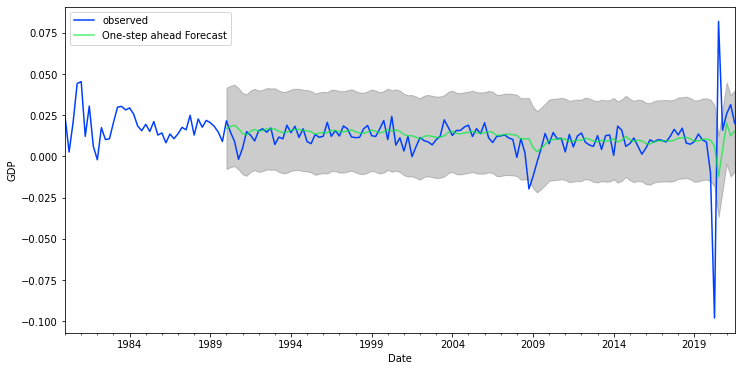

In [61]:
ax = gdp_diff['1980':].plot(label='observed', figsize=(12, 6))
arima_res_pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)

ax.fill_between(arima_res_pred_ci.index,
                arima_res_pred_ci.iloc[:, 0],
                arima_res_pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('GDP')
plt.legend()

plt.show()

In [62]:
arima_forecasted = arima_res_pred.predicted_mean
gdp_truth = gdp_diff['1990-01-01':]

# Compute the mean square error
mse = ((arima_forecasted - gdp_truth) ** 2).mean()
print('The Mean Squared Error of SARIMA forecasts is {}'.format(round(mse, 5)))

The Mean Squared Error of SARIMA forecasts is 0.0002


In [63]:
# Get forecast n steps ahead in future
arima_pred_uc = arima_res.get_forecast(steps=4)

# Get confidence intervals of forecasts
arima_pred_ci = arima_pred_uc.conf_int()

Once again, the four-quarter ahead forecast indicates a continuation of the GDP trend.

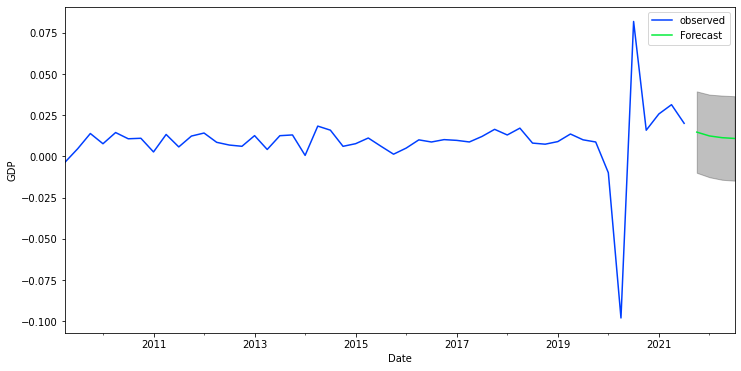

In [64]:
ax = gdp_diff[-50:].plot(label='observed', figsize=(12, 6))
arima_pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(arima_pred_ci.index,
                arima_pred_ci.iloc[:, 0],
                arima_pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('GDP')

plt.legend()
plt.show()

## SARIMA 

Let's now see if allowing for seasonality, things change or not.

In [48]:
auto_model_4 = pm.auto_arima(gdp_diff, seasonal=True, m=4,
                           suppress_warnings=True,
                           trace=True, 
                           stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[4] intercept   : AIC=-1740.481, Time=0.31 sec
 ARIMA(0,1,0)(0,0,0)[4] intercept   : AIC=-1597.074, Time=0.04 sec
 ARIMA(1,1,0)(1,0,0)[4] intercept   : AIC=-1682.846, Time=0.17 sec
 ARIMA(0,1,1)(0,0,1)[4] intercept   : AIC=-1741.398, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[4]             : AIC=-1599.073, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[4] intercept   : AIC=-1737.666, Time=0.16 sec
 ARIMA(0,1,1)(1,0,1)[4] intercept   : AIC=-1740.352, Time=0.30 sec
 ARIMA(0,1,1)(0,0,2)[4] intercept   : AIC=-1741.914, Time=0.39 sec
 ARIMA(0,1,1)(1,0,2)[4] intercept   : AIC=-1739.005, Time=0.34 sec
 ARIMA(0,1,0)(0,0,2)[4] intercept   : AIC=-1595.682, Time=0.10 sec
 ARIMA(1,1,1)(0,0,2)[4] intercept   : AIC=-1721.140, Time=0.55 sec
 ARIMA(0,1,2)(0,0,2)[4] intercept   : AIC=-1739.503, Time=0.83 sec
 ARIMA(1,1,0)(0,0,2)[4] intercept   : AIC=-1684.796, Time=0.32 sec
 ARIMA(1,1,2)(0,0,2)[4] intercept   : AIC=-1734.966, Time=0.47 sec
 ARIMA(0,1,1)(0,0,2

The model suggested is a SARIMA (2,1,1)(0,0,1)[4]. 

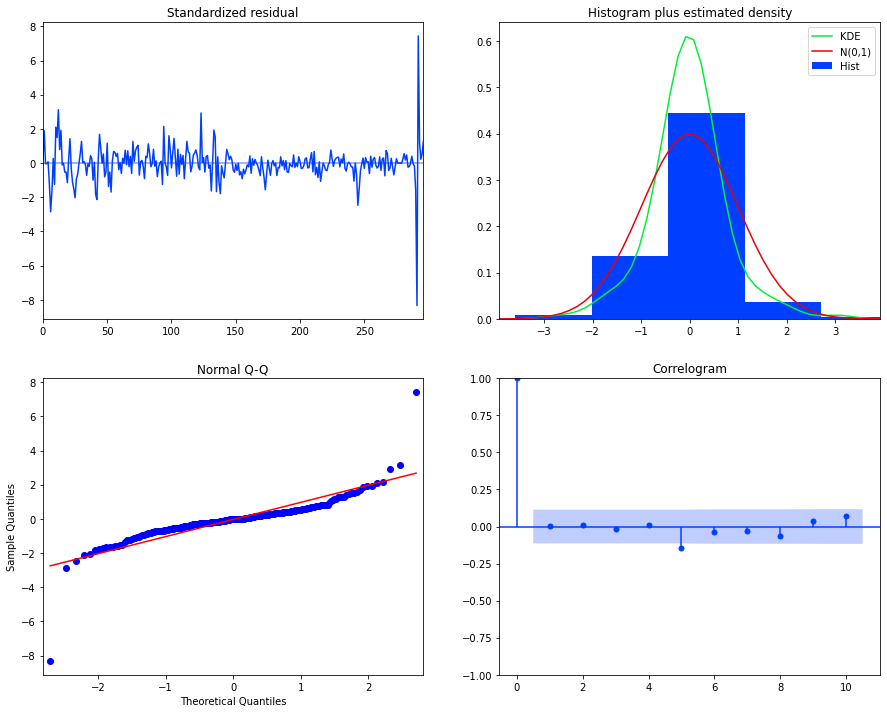

In [49]:
auto_model_4.plot_diagnostics(figsize=(15, 12))
plt.show()

From the diagnostics plot, once again, we see that the model seems to be quite stable.

In [50]:
# SARIMA model
sarima_2 = sm.tsa.statespace.SARIMAX(gdp_diff,
                                order=(2, 1, 1),
                                seasonal_order=(0, 0, 1, 4),
                                enforce_stationarity=False,
                                enforce_invertibility=False,
                                trend=None)

sarima_2_res = sarima_2.fit()

print(sarima_2_res.summary())

/Users/lucadonghi/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  warnings.warn('No frequency information was'
/Users/lucadonghi/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  warnings.warn('No frequency information was'


                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                  298
Model:             SARIMAX(2, 1, 1)x(0, 0, 1, 4)   Log Likelihood                 861.237
Date:                           Fri, 24 Dec 2021   AIC                          -1712.473
Time:                                   10:18:17   BIC                          -1694.107
Sample:                               04-01-1947   HQIC                         -1705.115
                                    - 07-01-2021                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1143      0.036      3.139      0.002       0.043       0.186
ar.L2          0.1477      0.057      2.590

In [51]:
sarima_2_res_pred = sarima_2_res.get_prediction(start=pd.to_datetime('1990-01-01'), dynamic=False)
sarima_2_res_pred_ci = sarima_2_res_pred.conf_int()

Once again, we notice predictions that are smoother than actual results, but the MSE slightly improves.

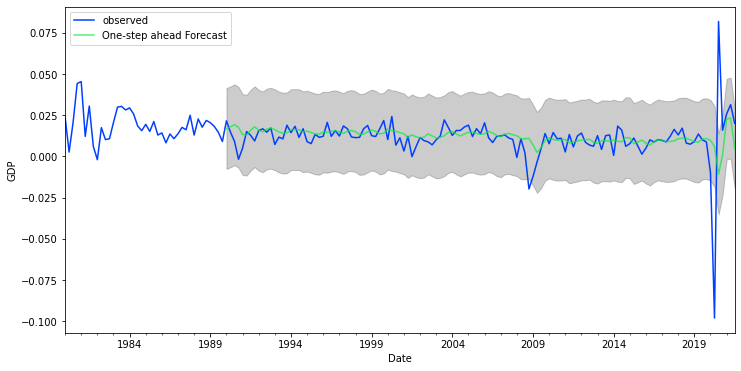

In [53]:
ax = gdp_diff['1980':].plot(label='observed', figsize=(12, 6))
sarima_2_res_pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)

ax.fill_between(sarima_2_res_pred_ci.index,
                sarima_2_res_pred_ci.iloc[:, 0],
                sarima_2_res_pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('GDP')
plt.legend()

plt.show()

In [54]:
sarima_2_forecasted = sarima_2_res_pred.predicted_mean
gdp_truth = gdp_diff['1990-01-01':]

# Compute the mean square error
mse = ((sarima_2_forecasted - gdp_truth) ** 2).mean()
print('The Mean Squared Error of SARIMA forecasts is {}'.format(round(mse, 5)))

The Mean Squared Error of SARIMA forecasts is 0.00019


In [55]:
# Get forecast n steps ahead in future
sarima_2_pred_uc = sarima_2_res.get_forecast(steps=4)

# Get confidence intervals of forecasts
sarima_2_pred_ci = sarima_2_pred_uc.conf_int()

Here again, we notice the model suggesting the GDP will decline in the coming months, thus our recommendation (irrespectiely of the model chosen) will be to reduce our exposure to equities and increase it toward bonds.

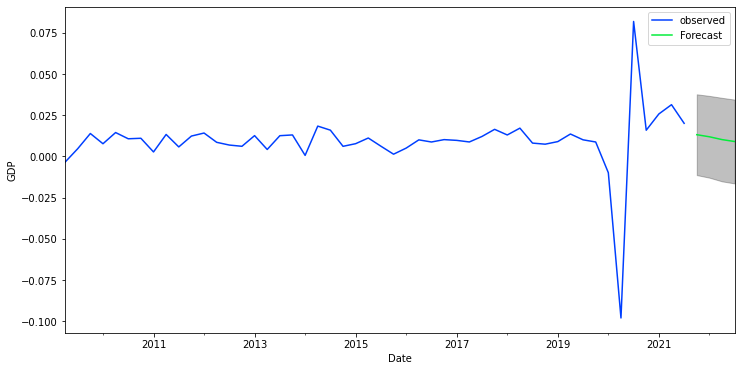

In [56]:
ax = gdp_diff[-50:].plot(label='observed', figsize=(12, 6))
sarima_2_pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(sarima_2_pred_ci.index,
                sarima_2_pred_ci.iloc[:, 0],
                sarima_2_pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('GDP')

plt.legend()
plt.show()